# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Satellite Imagery Feature Detection

## Notebook 3: Satellite Image Segmentation Using Simple U-Net

### Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2018

##### Main text: Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc


U-Net shown below was originally proposed by [Olaf Ronneberger, Philipp Fischer and Thomas Brox](https://arxiv.org/abs/1505.04597) for biomedical image segmentation. <br>

![unet_schema](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FSatellite%20Image%20Segmentation%2Funet_schema.png)

A purpose of this architecture was designing a network that could be trained on limited number of annotated (labeled) samples. Training of this network relies on data augmentation.

The key element of the architecture is the combination of two symmetrical phases: contracting phase (descending part of the U-shape) is capable of capturing content patterns of different scales; expanding phase (ascending part of the U-shape) enabling localization of patterns.

More detailed description of the two parts:

1. Contracting path (down path of the U-shape): repeated convolution/max pooling cycles, such that each $3 \times 3$ unpadded convolution - followed by ReLU - **doubles the number of channels** by applying filters, and each $2 \times 2$-stride 2 max pooling **shrinks image by 50%**
2. Expansive path (up path of the U-shape): repeated cycles of $2 \times 2$ up-convolution, each of them **reduces number of feature map channels by 50%**. During the up-move throught the net each output of up-convolution is concatenated with the correspondingly cropped feature map from the contracting path. Up-convolution and concatenation is followed by two $3 \times 3$ convolutions with ReLU
3. The final layer is a $1 \times 1$ convolution mapping each 64-component feature vector to probabilities of the necessary number of classes.

The total number of convolutional and u-convolutional layers in the architecture is 23.

For this notebook construct and train a not so deep U-Net using Keras to illustrate how this type of architecture can be used for satellite image segmentation. 

The simplified architecture has one convolution, followed by one maxpool, followed by another convolution, and then up-convolution concatenated with the output of the first convolution, third convolution (all with ReLU activation) and final 1x1 convolution layer with sigmoid activation (see plot below). 

Note that input images have multiple channels. <br>
Since we have 5 possible classes for every pixel, output map should also have multiple channels: 5.

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.optimizers import Adam

/home/yuri/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/yuri/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yuri/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Create a function generating network with given architecture. 

In [2]:
def simple_unet_model(n_classes=5, im_sz=160, n_channels=8, n_filters_start=4, growth_factor=2):
    # Creating network model using functional API:
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    n_filters *= growth_factor  # increase number of filters when going down the U-Net
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    n_filters //= growth_factor  # decrease number of filters when going up the U-Net
    upconv = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv2)
    concat = concatenate([conv1, upconv])
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(concat)
    output = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv3)
    model = Model(inputs=inputs, outputs=output)
    # Compiling model with ADAM optimizer and logloss (aka binary crossentropy) as loss function
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

It is recommended not to feed whole satellite images to the network. <br>
Instead, resample small patches of size $160 \times 160$ and train the model with such samples. <br>
This is a common practice in image segmentation.

Note that for illustrative purposes this example uses a simpler shallow version of U-Net architecture with small number of convolutional filters.

Create U-Net model using function `simple_unet_model()` and see its summary:

In [3]:
model = simple_unet_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 8)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 4)  292         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 80, 80, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 80, 80, 8)    296         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_tra

The output is created with 5 channels - one per segmentation class. Each channel will contain probabilities of pixel belonging to the corresponding class.

Save and show the neural network architecture:

In [4]:
%matplotlib inline

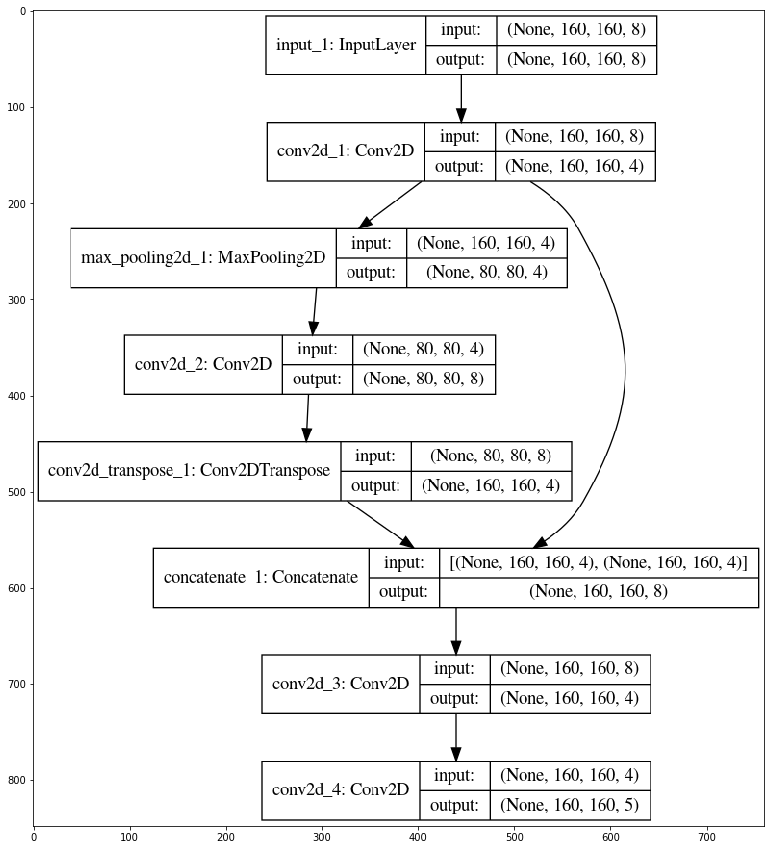

In [5]:
import imageio
import matplotlib as mpl
from matplotlib import pyplot as plt 
from keras.utils import plot_model
mpl.rcParams['figure.figsize'] = (15,15)  # plot sizes

plot_model(model, to_file='simple_unet.png', show_shapes=True)
plt.imshow(imageio.imread('simple_unet.png'))

Now use constructed network to make a segmentation of train image with `id='22'` :

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f89e2ac4ac8>)

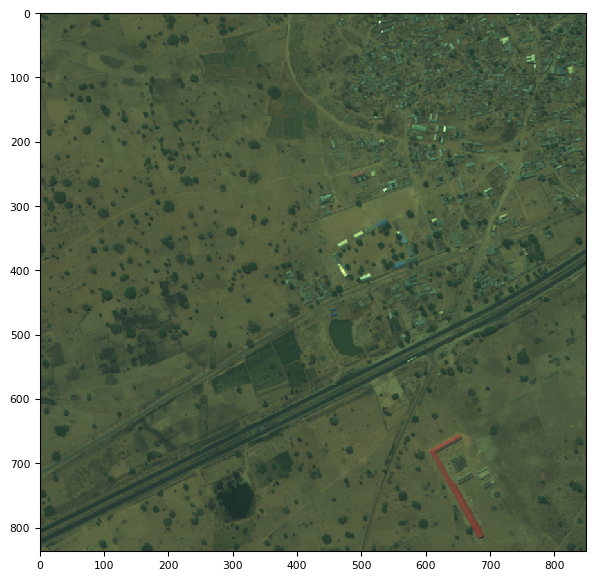

In [6]:
import tifffile as tiff
id = '22'
img = tiff.imread('data/mband/{}.tif'.format(id))
tiff.imshow(img.copy()[(4,2,1), :, :])  # select RGB channels

Before training network normalize the image, so that all values are in [-1.0,1.0]. <br>
Create function that does that.

In [8]:
def normalize(img):
    min = img.min()
    max = img.max()
    return 2.0 * (img - min) / (max - min) - 1.0

img_normalized = normalize(img)
print('Range before normalization: ',img.min(),img.max())
print('Range after normalization: ',img_normalized.min(),img_normalized.max())

Range before normalization:  143 2047
Range after normalization:  -1.0 1.0


The following function takes: 
- image *'x'* 
- trained model 
- patch size 
- number of classes

It returns predicted probabilities of each class for every pixel of *'x'* in array with shape `(extended_height, extended_width, n_classes)`, where `extended_height` and `extended_width` are extended dimensions of `x` that make whole number of patches in the image.

In [10]:
import numpy as np
import math

def predict(x, model, patch_sz=160, n_classes=5):
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]

    # make extended img so that it contains integer number of patches
    npatches_vertical = math.ceil(img_height/patch_sz)
    npatches_horizontal = math.ceil(img_width/patch_sz)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal
    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    # fill extended image with mirror reflections of neighbors:
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2*img_height - i - 1, :, :]
    for j in range(img_width, extended_width):
        ext_x[:, j, :] = ext_x[:, 2*img_width - j - 1, :]

    # now assemble all patches in one array
    patches_list = []
    for i in range(0, npatches_vertical):
        for j in range(0, npatches_horizontal):
            x0, x1 = i * patch_sz, (i + 1) * patch_sz
            y0, y1 = j * patch_sz, (j + 1) * patch_sz
            patches_list.append(ext_x[x0:x1, y0:y1, :])
    # model.predict() needs numpy array rather than a list
    patches_array = np.asarray(patches_list)
    # predictions:
    patches_predict = model.predict(patches_array, batch_size=4)
    prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        i = k // npatches_horizontal
        j = k % npatches_vertical
        x0, x1 = i * patch_sz, (i + 1) * patch_sz
        y0, y1 = j * patch_sz, (j + 1) * patch_sz
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
    return prediction[:img_height, :img_width, :]

Note that method `predict()` in the cell above uses `batch _size`. Batch prediction is usually used when data set to be predicted is very large and may not fit in memory. In such case prediction will be done batch by batch.

Transpose the image to satisfy default shape in Keras and create predicted mask of the image.

Note that this time `model` was not trained, i.e. it has randomly initiated parameters.

In [11]:
img_t = img_normalized.transpose([1,2,0])  # keras uses last dimension for channels by default
predicted_mask = predict(img_t, model).transpose([2,0,1])  # channels first to plot
predicted_mask.shape

(5, 837, 849)

Show image of the created mask. <br>
On this image use color codes of the first 5 colors for the 5 classes. <br>
Create function that takes a mask created by *'predict()'* and a threshold and returns an RGB file that can be shown by *'imshow()'*. <br>

In function *'picture_from_mask()'* created below:
- Dictionary variable *'colors'* contains first 5 colors corresponding to the 5 classes of objects. Color of each class is defined as combination of 3 basic colors
- Dictionary *'z_order'* creates special order of classes in which the mask-image is created. If the same pixel has high enough probability of belonging to several classes then the pixel is marked as highest of them in *'z_order'*. Basically, this means that in the loop over *'z_order'* color of the next significant class replaces the color of the previous one.
- A class of a pixel is considered "significant" if probability of that class is greater than "threshold".

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f89e2962ac8>)

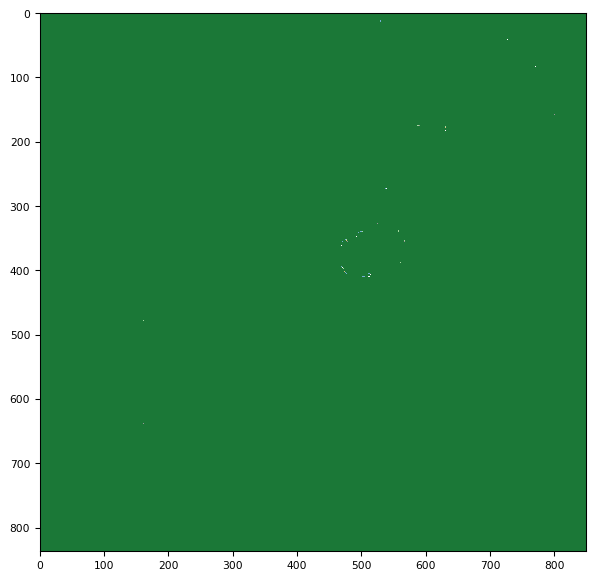

In [13]:
def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150],  # Buildings (grey)
        1: [223, 194, 125],  # Roads & Tracks (light orange)
        2: [27, 120, 55],    # Trees (green)
        3: [166, 219, 160],  # Crops (greyish-green)
        4: [116, 173, 209]   # Water (blue)
    }
    z_order = {
        1: 3,
        2: 4,
        3: 0,
        4: 1,
        5: 2
    }
    pict = 255*np.ones(shape=(3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1, 6):
        cl = z_order[i]
        for ch in range(3):
            pict[ch,:,:][mask[cl,:,:] > threshold] = colors[cl][ch]
    return pict

y_pict = picture_from_mask(predicted_mask, threshold = 0.5)
tiff.imshow(y_pict)

Such prediction is obviously not good. <br>
The reason is: all weights in the model are only randomly initialized, but not trained. 

For simplicity use for training only one satellite image and split it between train (75% of the image) and validation (25%).

In [14]:
id = '22'
img = tiff.imread('data/mband/{}.tif'.format(id))  # read mband image
mask = tiff.imread('data/gt_mband/{}.tif'.format(id)) / 255  # read mask and normalize it

Normalize the image using *'normalize()'*, split it into train and test and change the shape to Keras default.

In [15]:
print(img_normalized.shape)

(8, 837, 849)


In [16]:
img_normalized = normalize(img) # actually, has been done before for this image, but not for others
print('img_normalized:',img_normalized.shape) 
train_xsz = int(3/4 * img.shape[1])

# Making channels dimension last in the shape for Keras
# For train
img_train = img_normalized[:, :train_xsz, :].transpose([1, 2, 0])
mask_train = mask[:, :train_xsz, :].transpose([1, 2, 0])

# For test
img_validation = img_normalized[:, train_xsz:, :].transpose([1, 2, 0])
mask_validation = mask[:, train_xsz:, :].transpose([1, 2, 0])

print('img_train:', img_train.shape)
print('img_validation:',img_validation.shape)

img_normalized: (8, 837, 849)
img_train: (627, 849, 8)
img_validation: (210, 849, 8)


We need to prepare 160x160 patches from both train and validation data to fit the model.
For example, below is one of such patches and its location on the image.

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f89e1088a20>)

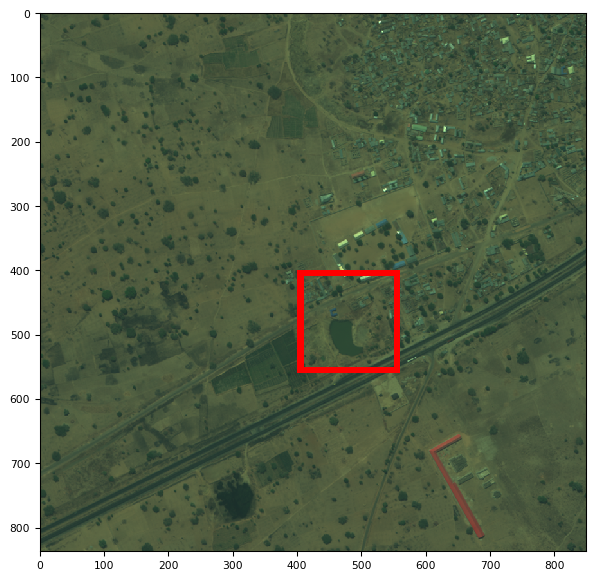

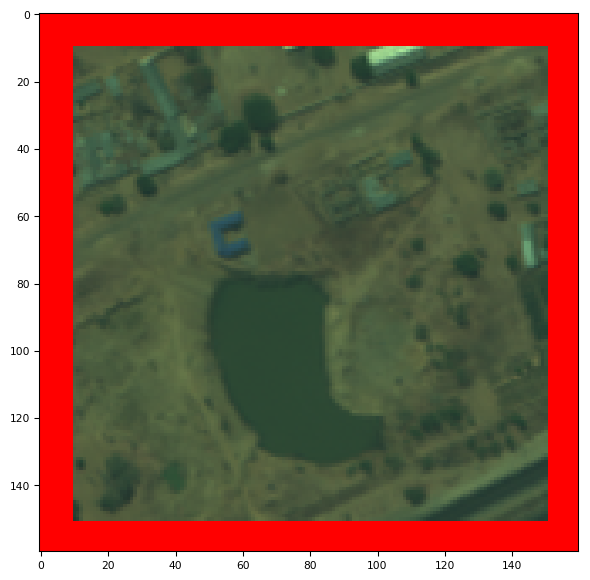

In [17]:
# show patch on image
xc=400
yc=400
img_copy_rgb=img[(4,2,1),:,:].copy()
red = [img_copy_rgb[0,:,:].max(), 0, 0]

for i in range(160):
    for j in range(160):
        if i<10 or i>150 or j<10 or j>150:
            img_copy_rgb[:,xc+i,yc+j]=red

tiff.imshow(img_copy_rgb)
tiff.imshow(img_copy_rgb[:,xc:(xc+160),yc:(yc+160)])

The following function `get_rand_patch()` picks random patch from an image and corresponding mask.
Then function `get_patches()` resamples patches from the image.

In [19]:
import random

def get_rand_patch(img, mask, sz=160):
    """
    :param img: ndarray with shape (x_sz, y_sz, num_channels)
    :param mask: ndarray with shape (x_sz, y_sz, num_classes)
    :param sz: size of random patch
    :return: patch with shape (sz, sz, num_channels)
    """
    assert len(img.shape) == 3 and img.shape[0] > sz \
    and img.shape[1] > sz \
    and img.shape[0:2] == mask.shape[0:2]
    
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    patch_img = img[xc:(xc + sz), yc:(yc + sz)]
    patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]
    return patch_img, patch_mask


def get_patches(img, mask, n_patches, sz=160):
    x = list()
    y = list()
    total_patches = 0
    while total_patches < n_patches:
        img_patch, mask_patch = get_rand_patch(img, mask, sz)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    print('Generated {} patches'.format(total_patches))
    return np.array(x), np.array(y)  # keras needs numpy arrays rather than lists


TRAIN_SZ = 200  # train size
x_train, y_train = get_patches(img_train, mask_train, n_patches=TRAIN_SZ, sz=160)
VAL_SZ = 50     # validation size
x_val, y_val = get_patches(img_validation, mask_validation, n_patches=VAL_SZ, sz=160)

Generated 200 patches
Generated 50 patches


Show one of the selected patches using code below. 

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f89e01cda58>)

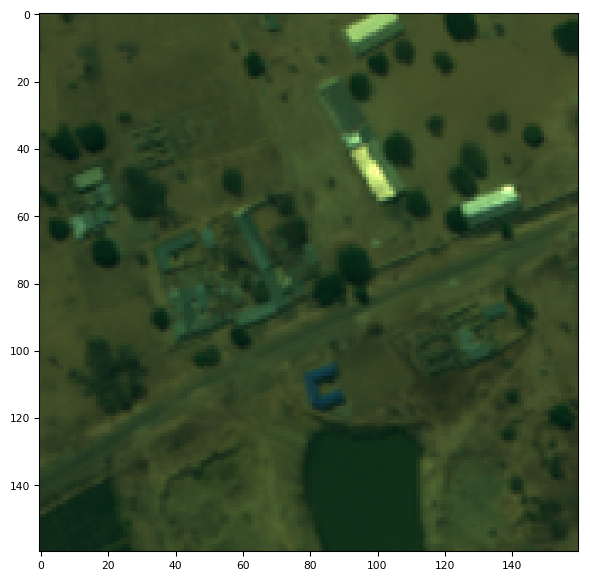

In [20]:
p = x_train[88][:,:,(4,2,1)] # select RGB channels
p -= p.min() # make values positive
tiff.imshow(p)  # plot only RGB channels for 88's train patch

Train the model

In [21]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard

# Now training the model:
N_EPOCHS = 100
BATCH_SIZE = 32
# ask Keras to save best weights (in terms of validation loss) into file:
model_checkpoint = ModelCheckpoint(filepath='weights_simple_unet.hdf5', monitor='val_loss', save_best_only=True)
# ask Keras to log each epoch loss:
csv_logger = CSVLogger('log.csv', append=True, separator=';')
# ask Keras to log info in TensorBoard format:
tensorboard = TensorBoard(log_dir='tensorboard_simple_unet/', write_graph=True, write_images=True)
# Fit:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          verbose=2, shuffle=True,
          callbacks=[model_checkpoint, csv_logger, tensorboard],
          validation_data=(x_val, y_val))

/home/yuri/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Train on 200 samples, validate on 50 samples
Epoch 1/100
 - 7s - loss: 0.7634 - val_loss: 0.7250
Epoch 2/100
 - 6s - loss: 0.7024 - val_loss: 0.6802
Epoch 3/100
 - 6s - loss: 0.6713 - val_loss: 0.6575
Epoch 4/100
 - 6s - loss: 0.6487 - val_loss: 0.6171
Epoch 5/100
 - 6s - loss: 0.5931 - val_loss: 0.5230
Epoch 6/100
 - 6s - loss: 0.4916 - val_loss: 0.4050
Epoch 7/100
 - 6s - loss: 0.3907 - val_loss: 0.3334
Epoch 8/100
 - 6s - loss: 0.3510 - val_loss: 0.3265
Epoch 9/100
 - 6s - loss: 0.3555 - val_loss: 0.3270
Epoch 10/100
 - 7s - loss: 0.3518 - val_loss: 0.3193
Epoch 11/100
 - 6s - loss: 0.3438 - val_loss: 0.3158
Epoch 12/100
 - 6s - loss: 0.3408 - val_loss: 0.3152
Epoch 13/100
 - 6s - loss: 0.3397 - val_loss: 0.3132
Epoch 14/100
 - 6s - loss: 0.3380 - val_loss: 0.3110
Epoch 15/100
 - 6s - loss: 0.3366 - val_loss: 0.3093
Epoch 16/100
 - 6s - loss: 0.3354 - val_loss: 0.3080
Epoch 17/100
 - 6s - loss: 0.3343 - val_loss: 0.3066
Epoch 18/100
 - 6s - loss: 0.3332 - val_loss: 0.3055
Epoch 19/1

Next predict the same image (all classes) using the trained model: 

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f8990fa7e48>)

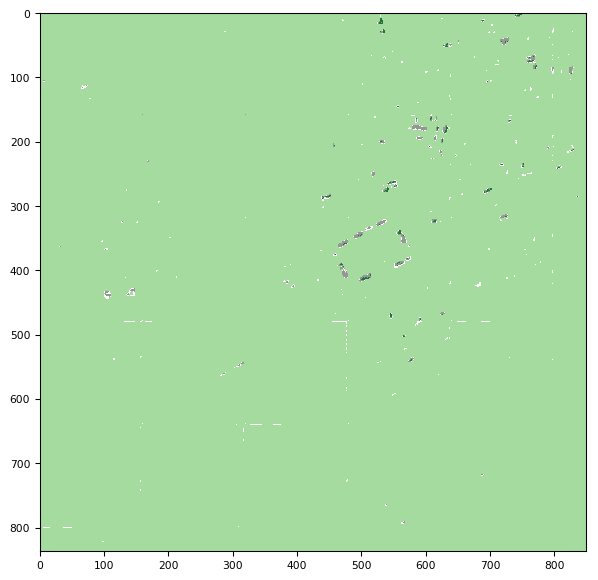

In [22]:
img_t = img_normalized.transpose([1,2,0])  # keras uses last dimension for channels by default
predicted_mask = predict(img_t, model).transpose([2,0,1])  # channels first to plot
y_pict_2 = picture_from_mask(predicted_mask, threshold = 0.5)
tiff.imshow(y_pict_2)

Still not perfect, but it is definitely better than it was before training and it is a good starting point.

Do not forget to view TensorBoard graphs by calling from Terminal:

*tensorboard --logdir=tensorboard_simple_unet*

and then navigate in browser to *'localhost:6006'*.